# Bayesian Poisson Regression

Describing the relationship between number of times a person sneezes with alcohol consumption and medicinal intake

In [1]:
#Import Turing, Distributions and DataFrames
using Turing, Distributions, DataFrames, Distributed

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

## Generate data

Make a fake dataset

In [2]:
theta_noalcohol_meds = 1
theta_alcohol_meds = 3
theta_noalcohol_nomeds = 6
theta_alcohol_nomeds = 36

# number of samples
q = 100

# Sample 4 poissons
noalcohol_meds = Poisson(theta_noalcohol_meds)
alcohol_meds = Poisson(theta_alcohol_meds)
noalcohol_nomeds = Poisson(theta_noalcohol_nomeds)
alcohol_nomeds = Poisson(theta_alcohol_meds)

nsneeze_data = vcat(rand(noalcohol_meds, q), rand(alcohol_meds, q), rand(noalcohol_nomeds, q), rand(alcohol_nomeds, q) )
alcohol_data = vcat(zeros(q), ones(q), zeros(q), ones(q) )
meds_data = vcat(zeros(q), zeros(q), ones(q), ones(q) )

df = DataFrame(nsneeze = nsneeze_data, alcohol_taken = alcohol_data, nomeds_taken = meds_data, product_alcohol_meds = meds_data.*alcohol_data)

# Look at a few random rows
df[sample(1:nrow(df), 5, replace = false), :]

,nsneeze,alcohol_taken,nomeds_taken,product_alcohol_meds
,Int64,Float64,Float64,Float64
1,8,0.0,1.0,0.0
2,6,1.0,1.0,1.0
3,1,0.0,0.0,0.0
4,2,1.0,0.0,0.0
5,2,1.0,0.0,0.0


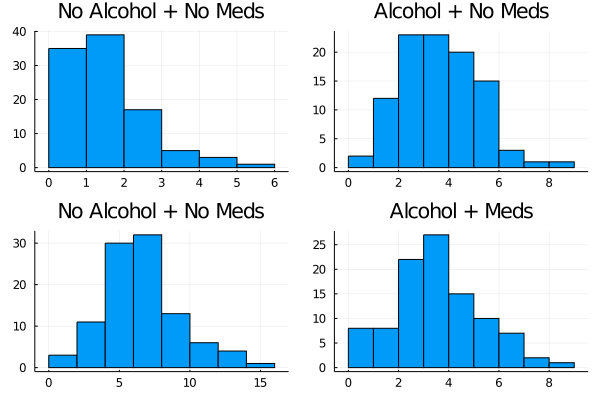

In [3]:
# Visualize

p1 = Plots.histogram(df[(df[:,:alcohol_taken] .== 0) .& (df[:,:nomeds_taken] .== 0), 1], title = "No Alcohol + No Meds")  
p2 = Plots.histogram((df[(df[:,:alcohol_taken] .== 1) .& (df[:,:nomeds_taken] .== 0), 1]), title = "Alcohol + No Meds")  
p3 = Plots.histogram((df[(df[:,:alcohol_taken] .== 0) .& (df[:,:nomeds_taken] .== 1), 1]), title = "No Alcohol + No Meds")  
p4 = Plots.histogram((df[(df[:,:alcohol_taken] .== 1) .& (df[:,:nomeds_taken] .== 1), 1]), title = "Alcohol + Meds")  
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)


In [4]:
# Convert to Matrix

data = Matrix(df[:,[:alcohol_taken, :nomeds_taken, :product_alcohol_meds]])
data_labels = df[:,:nsneeze]
data

400×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [5]:
# Normalize
data = (data .- mean(data, dims=1)) ./ std(data, dims=1)

400×3 Array{Float64,2}:
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
  ⋮                    
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988

### Poisson Regression Model

* x is independent variables
* y is element to predic
* n is number of observations
* $\sigma^2$ is std for all priors

4 coefficients for poisson regression 

* `b1` is alcohol on number of sneeses
* `b2` is coefficient of taking in no medicines on number of sneezes
* `b3` interaction effect

`for` block creates a variable which is the weighted combination of the input features. Then observe likelihood of calculating `theta` given the actual label, `y[i]`

In [6]:
@model poisson_regression(x, y, n, σ_2) = begin
    b0 ~ Normal(0, σ_2)
    b1 ~ Normal(0, σ_2)
    b2 ~ Normal(0, σ_2)
    b3 ~ Normal(0, σ_2)
    for i = 1:n
        theta = b0 + b1*x[i, 1] + b2*x[i, 2] + b3*x[i, 3]
        y[i] ~ Poisson(exp(theta))
    end
end;

### Sampling from the posterior 

Sample using `NUTS`, multiple chains using mapreduce.

In [7]:
# N observations
n, _ = size(data)

# sample
num_chains = 4

chain = mapreduce(
    c -> sample(
        poisson_regression(data, data_labels, n, 10), NUTS(200,0.65), 2500, discad_adapt=false
    ),
    chainscat,
    1:num_chains
);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████

### Diagnostics

Use Gelman, Rubin, Brooks to check for convergence

In [8]:
gelmandiag(chain)

Gelman, Rubin, and Brooks Diagnostic
  parameters      psrf     97.5% 
      Symbol   Float64   Float64 

          b0    1.0008    1.0024
          b1    1.0027    1.0087
          b2    1.0029    1.0093
          b3    1.0030    1.0096


Transform coefficients and recover theta values. Take exponent of means to get a better comparison of the relative values, then compare with the intuitive meaning described earlier.

In [10]:
# first chain
c1 = chain[:,:,1]

# exponentiated means
b0_exp = exp(mean(c1[:b0]))
b1_exp = exp(mean(c1[:b1]))
b2_exp = exp(mean(c1[:b2]))
b3_exp = exp(mean(c1[:b3]))

print("The exponent of the meaned values of the weights (or coefficients are): \n")
print("b0: ", b0_exp, " \n", "b1: ", b1_exp, " \n", "b2: ", b2_exp, " \n", "b3: ", b3_exp, " \n")
print("The posterior distributions obtained after sampling can be visualised as :\n")

The exponent of the meaned values of the weights (or coefficients are): 
b0: 2.79661987573227 
b1: 1.7310008958395495 
b2: 2.4081861390247945 
b3: 0.46265736788722733 
The posterior distributions obtained after sampling can be visualised as :


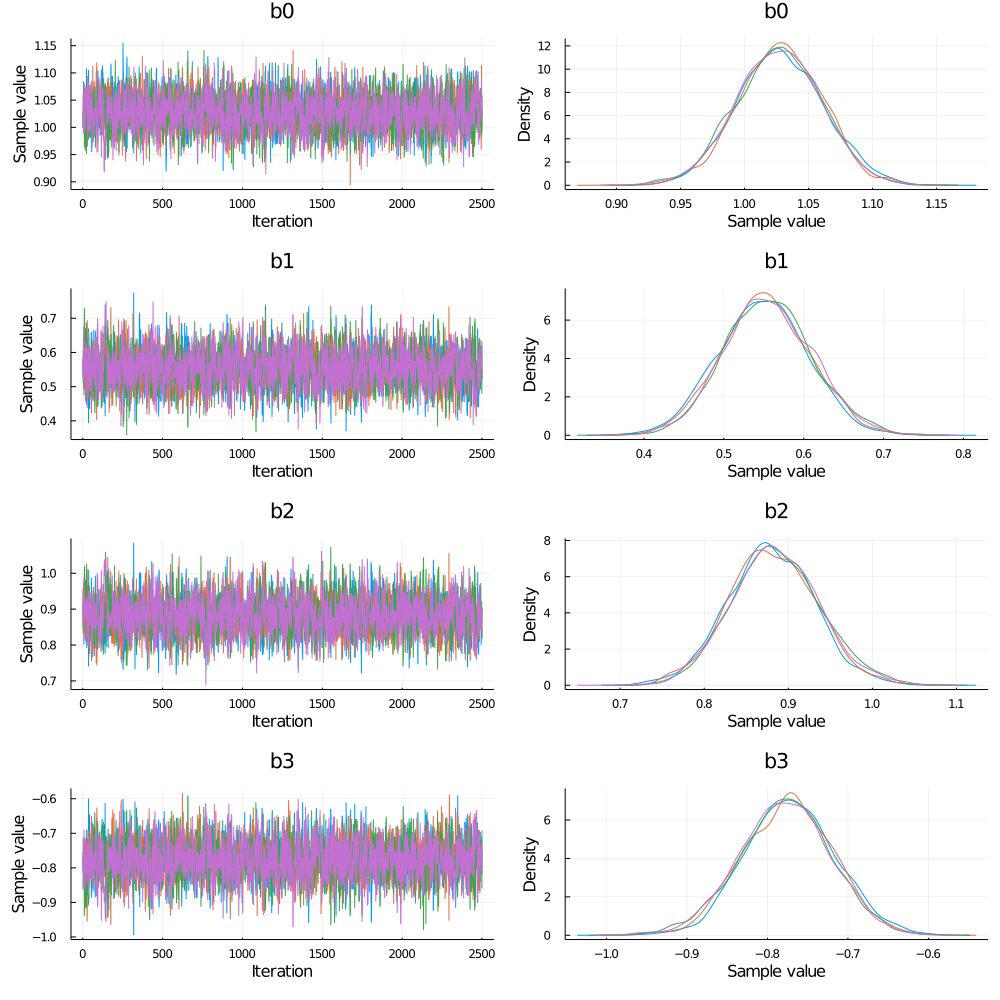

In [11]:
plot(chain)

Remembering back to the generated values, these estimated parameters track since number of sneezes was more sensitive to medicinal intake compared to alcohol consumption. Also weaker dependence on interaction, which is shown in b3.